In [37]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import nltk

In [39]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [40]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

**DOWNLOADING DATA AND READING DATA**

In [48]:
stock_price = pd.read_csv('/content/stock_data.csv')
stock_headlines = pd.read_csv('/content/india-news-headlines.csv')

In [49]:
stock_price.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
stock_price.head()


,Date,Close,compound,negative,neutral,positive,Open,High,Low,Volume
0,2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
1,2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2,2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
3,2001-01-05,0.292411,0.9253,0.104,0.744,0.152,0.302455,0.310268,0.286830,412356000.0
4,2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0


In [46]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [47]:
len(stock_price), len(stock_headlines)

(435, 1071662)

In [50]:
stock_price.isna().any()

Date        False
Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [51]:
stock_headlines.isna().any()

publish_date         False
headline_category    False
headline_text         True
dtype: bool

**2.1 STOCK PRICE DATA**

In [52]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price.head()

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0


In [53]:
stock_headlines = stock_headlines.drop_duplicates()

In [54]:
# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

In [55]:
# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])
# Convert 'headline_text' column to string
stock_headlines['headline_text'] = stock_headlines['headline_text'].astype(str)




# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2011-05-04,"Ready: Character Dheela,Salman not interested ..."
2011-05-05,"The Age of Sinnocence,3 arrested for cheating ..."
2011-05-06,"Katrina's tribute to Madhubala,Delhi's Deepika..."


In [61]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...
2002-10-31,0.286964,0.285536,0.293571,0.284286,295836800.0,"VHP to defy state ban on Togadia,HC issues not..."
2002-11-01,0.292143,0.284643,0.294643,0.283750,189828800.0,"India win Under-21 hockey tournament at Cairo,..."
2002-11-04,0.301607,0.294643,0.310357,0.291964,376818400.0,"Hockey: Spotlight on juniors,Indian hockey nee..."
2002-11-05,0.301786,0.299107,0.302857,0.291964,210694400.0,"Asia's biggest LPG tank set up in east China,M..."


In [56]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,0.265625,,,,,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,,,,,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,,,,,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,,,,,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,,,,,0.302455,0.303292,0.284598,373699200.0


In [57]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

In [59]:
# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [62]:
# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [63]:
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])

In [64]:
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

In [65]:
# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...,0.9253,0.104,0.744,0.152
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


In [66]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9253,0.104,0.744,0.152,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0


In [67]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

In [68]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9253,0.104,0.744,0.152,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0


In [69]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(435, 9)

In [70]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [71]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,4.350000e+02
mean,0.357500,-0.737655,0.114080,0.804407,0.081483,0.356451,0.365779,0.347987,3.468712e+08
std,0.062906,0.581601,0.039218,0.062351,0.046176,0.062876,0.063979,0.061351,1.897629e+08
min,0.242679,-0.999700,0.000000,0.000000,0.000000,0.241786,0.247321,0.238571,5.062960e+07
25%,0.305112,-0.998100,0.096000,0.781000,0.065000,0.303304,0.314648,0.300000,2.307228e+08
50%,0.359375,-0.995200,0.115000,0.806000,0.078000,0.358750,0.369420,0.349464,2.991352e+08
75%,0.415714,-0.922350,0.133500,0.829000,0.090500,0.415000,0.425357,0.406429,4.063388e+08
max,0.474821,0.995900,0.444000,1.000000,0.608000,0.470357,0.476786,0.460000,1.873670e+09


In [72]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 2001-01-02 to 2002-11-06
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     435 non-null    float64
 1   compound  435 non-null    float64
 2   negative  435 non-null    float64
 3   neutral   435 non-null    float64
 4   positive  435 non-null    float64
 5   Open      435 non-null    float64
 6   High      435 non-null    float64
 7   Low       435 non-null    float64
 8   Volume    435 non-null    float64
dtypes: float64(9)
memory usage: 34.0+ KB


Text(0, 0.5, 'Close Price ($)')

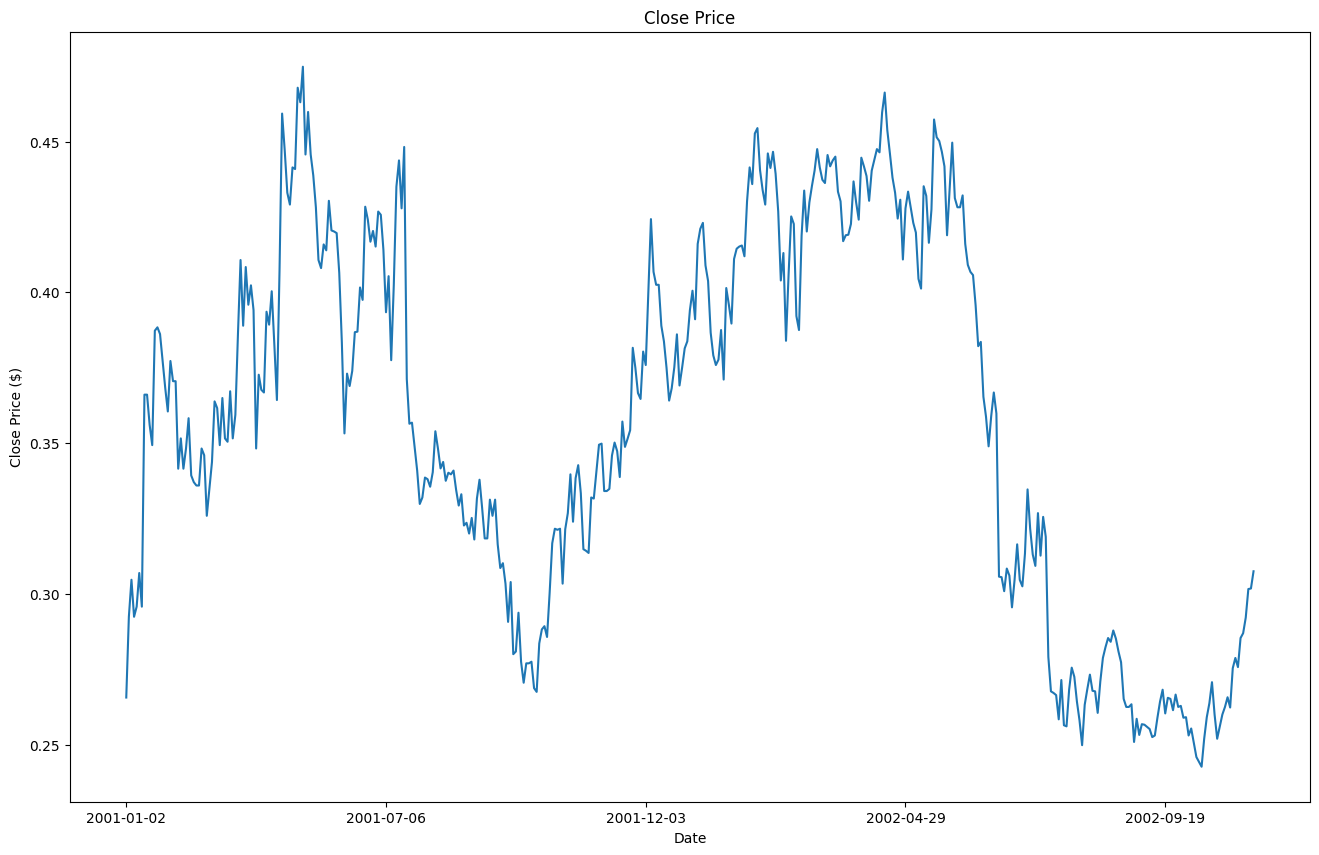

In [73]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [74]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,0.293368,-0.175914,0.121571,0.810143,0.068000,0.293088,0.304687,0.281728,566364000.0
2001-01-23,0.307717,0.094314,0.109714,0.818286,0.071714,0.304408,0.319196,0.293208,627395200.0
2001-01-24,0.318240,-0.125129,0.111429,0.825000,0.063429,0.320033,0.329400,0.306282,613112000.0


<Axes: xlabel='Date'>

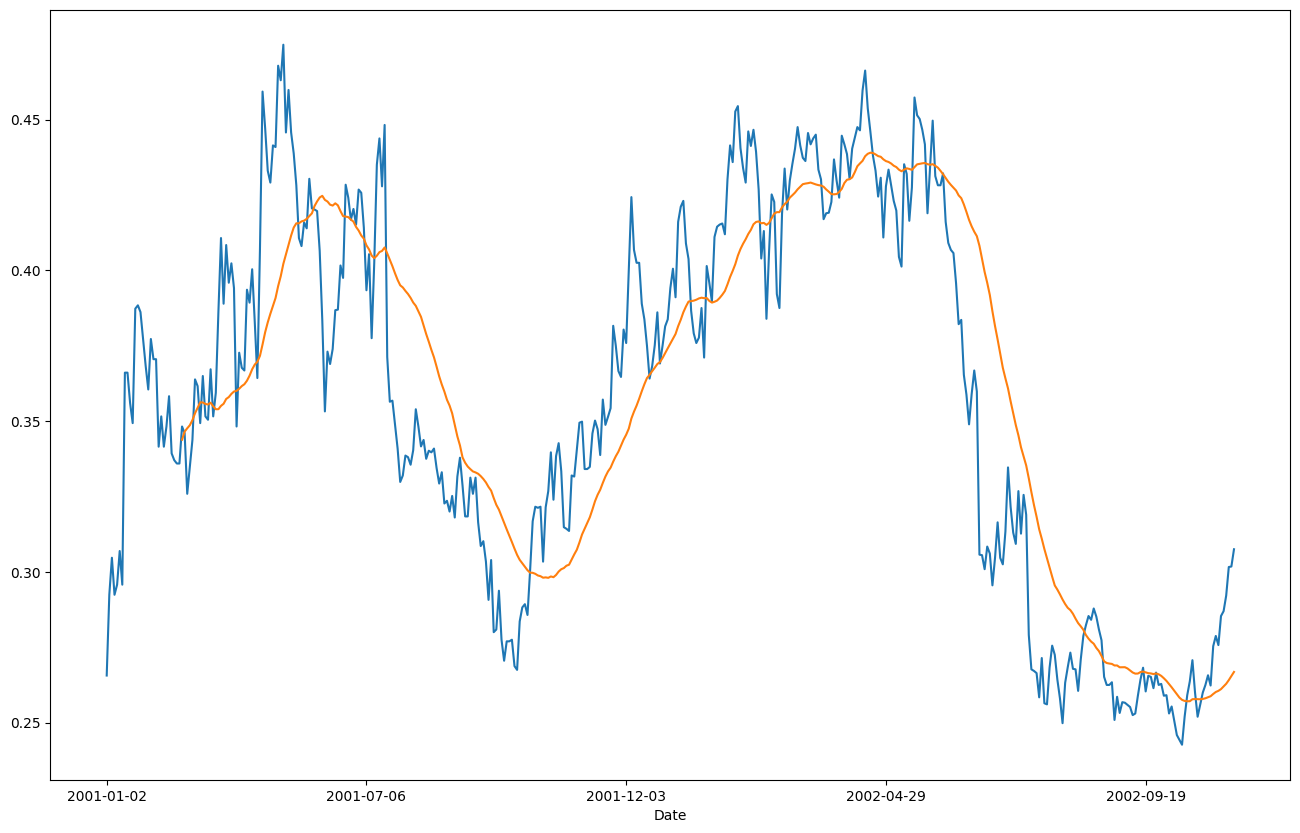

In [75]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [76]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9253,0.104,0.744,0.152,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0
...,...,...,...,...,...,...,...,...,...
2002-10-31,0.286964,-0.9980,0.118,0.814,0.068,0.285536,0.293571,0.284286,295836800.0
2002-11-01,0.292143,-0.9973,0.118,0.810,0.072,0.284643,0.294643,0.283750,189828800.0
2002-11-04,0.301607,-0.9920,0.116,0.786,0.098,0.294643,0.310357,0.291964,376818400.0


In [77]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 347
Number of records in Test Data: 88


In [78]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2001-01-03    0.292411
2001-01-04    0.304688
2001-01-05    0.292411
2001-01-08    0.295759
2001-01-09    0.306920
                ...   
2002-10-31    0.286964
2002-11-01    0.292143
2002-11-04    0.301607
2002-11-05    0.301786
2002-11-06    0.307500
Name: Close, Length: 434, dtype: float64

In [79]:
# shifting next day close
close_price_shifted = close_price.shift(-1)

# shifting next day compound
compound_shifted = compound.shift(-1)

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-01-03,0.292411,0.304688,0.6322,0.6648,817073600.0,0.258929,0.297991,0.257813
2001-01-04,0.304688,0.292411,0.6648,0.9253,739396000.0,0.323940,0.330357,0.300223
2001-01-05,0.292411,0.295759,0.9253,-0.9638,412356000.0,0.302455,0.310268,0.286830
2001-01-08,0.295759,0.306920,-0.9638,-0.9559,373699200.0,0.302455,0.303292,0.284598
2001-01-09,0.306920,0.295759,-0.9559,-0.5719,588929600.0,0.300223,0.315011,0.295759
2001-01-10,0.295759,0.366071,-0.5719,0.9295,580781600.0,0.297991,0.303571,0.286830
2001-01-23,0.366071,0.366071,0.9295,-0.9039,879530400.0,0.344866,0.373884,0.340402
2001-01-24,0.366071,0.356027,-0.9039,-0.9838,717091200.0,0.368304,0.369420,0.349330
2001-01-25,0.356027,0.349330,-0.9838,0.8926,489708800.0,0.367188,0.367188,0.352679


In [80]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2001-01-03    0.304688
2001-01-04    0.292411
2001-01-05    0.295759
2001-01-08    0.306920
2001-01-09    0.295759
                ...   
2002-10-30    0.286964
2002-10-31    0.292143
2002-11-01    0.301607
2002-11-04    0.301786
2002-11-05    0.307500
Name: close_price_shifted, Length: 433, dtype: float64

In [81]:
# setting the features dataset for prediction
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2001-01-03,0.292411,0.6322,0.6648,817073600.0,0.258929,0.297991,0.257813
2001-01-04,0.304688,0.6648,0.9253,739396000.0,0.323940,0.330357,0.300223
2001-01-05,0.292411,0.9253,-0.9638,412356000.0,0.302455,0.310268,0.286830
2001-01-08,0.295759,-0.9638,-0.9559,373699200.0,0.302455,0.303292,0.284598
2001-01-09,0.306920,-0.9559,-0.5719,588929600.0,0.300223,0.315011,0.295759
...,...,...,...,...,...,...,...
2002-10-30,0.285357,-0.9948,-0.9980,270676000.0,0.276607,0.292321,0.276429
2002-10-31,0.286964,-0.9980,-0.9973,295836800.0,0.285536,0.293571,0.284286
2002-11-01,0.292143,-0.9973,-0.9920,189828800.0,0.284643,0.294643,0.283750


In [82]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.57153811,  0.6354981 ,  0.66816997, ..., -0.84999847,
         -0.55836402, -0.82620163],
        [-0.46576664,  0.66816997,  0.92924434, ..., -0.28115115,
         -0.27626435, -0.4431443 ],
        [-0.57153811,  0.92924434, -0.96402085, ..., -0.46914525,
         -0.45135859, -0.5641131 ],
        ...,
        [-0.57384704, -0.99759471, -0.99228302, ..., -0.62500055,
         -0.58754494, -0.5919324 ],
        [-0.49231074, -0.99228302, -0.99739427, ..., -0.53750038,
         -0.45058288, -0.51774158],
        [-0.49076858, -0.99739427, -0.97434356, ..., -0.49844031,
         -0.51595232, -0.51774158]]),
 array([[-0.46576664],
        [-0.57153811],
        [-0.5426937 ],
        [-0.44653703],
        [-0.5426937 ],
        [ 0.06307346],
        [ 0.06307346],
        [-0.02345978],
        [-0.08115722],
        [ 0.24577198],
        [ 0.25538679],
        [ 0.23615718],
        [ 0.15923013],
        [ 0.08231169],
        [ 0.01499944],
        [ 0.15923013],
     

In [83]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]
y_train = y[0 : train_end]
y_test = y[train_end+1 : len(y)]

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (347, 7) and y: (347, 1)
Number of rows and columns in the Test set X: (85, 7) and y: (85, 1)


In [84]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (347, 7, 1)
Shape of Test set X: (85, 7, 1)


In [85]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [86]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
35/35 [==============================] - 11s 114ms/step - loss: 0.1098 - val_loss: 0.1408
Epoch 2/10
35/35 [==============================] - 1s 43ms/step - loss: 0.0738 - val_loss: 0.0964
Epoch 3/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0552 - val_loss: 0.0760
Epoch 4/10
35/35 [==============================] - 1s 39ms/step - loss: 0.0454 - val_loss: 0.0511
Epoch 5/10
35/35 [==============================] - 2s 53ms/step - loss: 0.0269 - val_loss: 0.0270
Epoch 6/10
35/35 [==============================] - 2s 45ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 7/10
35/35 [==============================] - 1s 40ms/step - loss: 0.0217 - val_loss: 0.0168
Epoch 8/10
35/35 [==============================] - 1s 36ms/step - loss: 0.0200 - val_loss: 0.0169
Epoch 9/10
35/35 [==============================] - 1s 32ms/step - loss: 0.0209 - val_loss: 0.0160
Epoch 10/10
35/35 [==============================] - 1s 35ms/step - loss: 0.0208 - val_loss: 0.0164


In [87]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


In [88]:
# performing predictions
predictions = model.predict(X_test)

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

3/3 [==============================] - 1s 8ms/step
Predictions:


array([[0.32268214],
       [0.31884566],
       [0.3190127 ],
       [0.3292764 ],
       [0.31938285]], dtype=float32)

In [89]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

85/85 [==============================] - 1s 7ms/step - loss: 0.0102
Train Loss = 0.0171
Test Loss = 0.0102


In [91]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 1.0549


In [90]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 1.0549


In [93]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

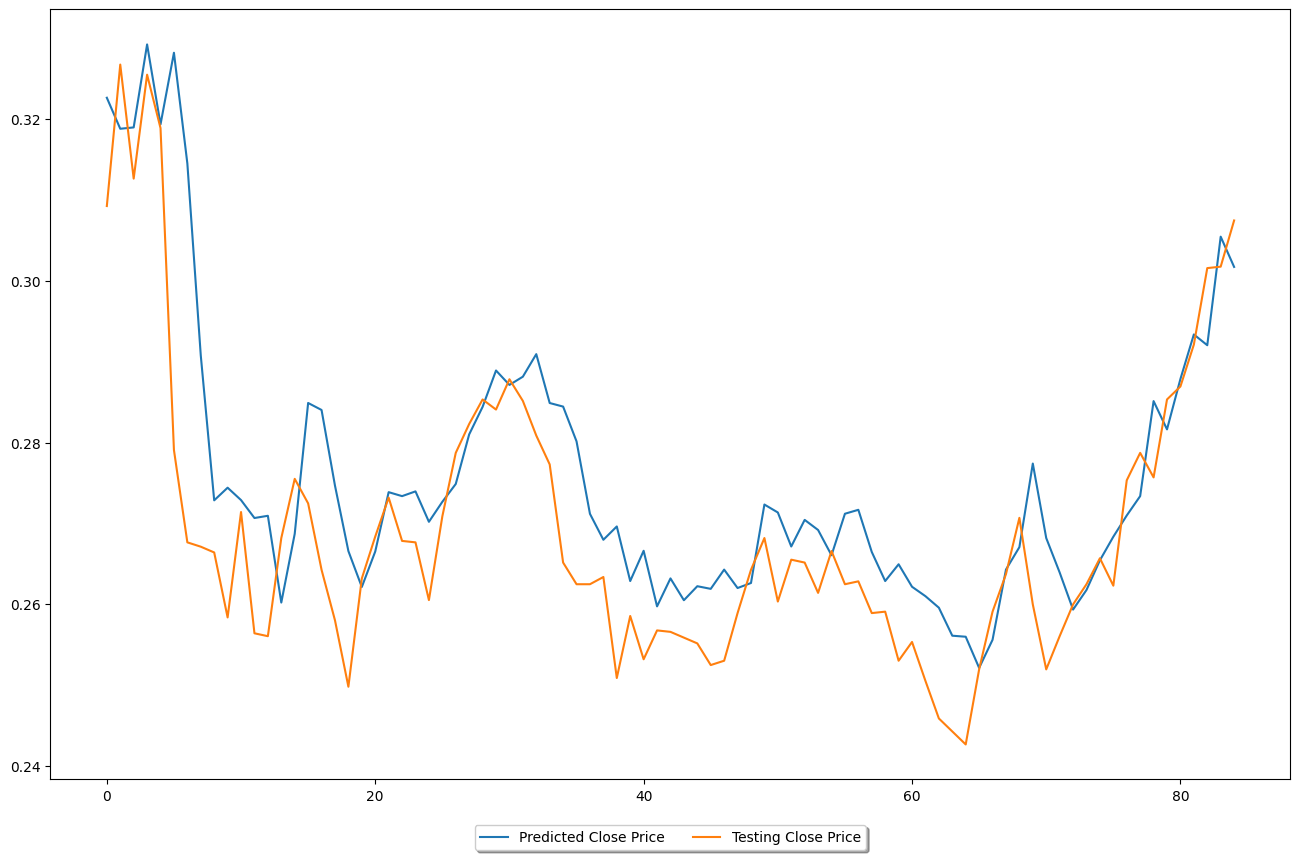

In [94]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()